# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Homework 7: Generative Models - Variational Autoencoders and GANs [100 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- For this homework **you do NOT need to restart the kernel and run the whole notebook again before you submit**.
- **You should SAVE your models, and do not retrain on notebook reruns**.
- In this homework we import general keras library objects. Feel free to experiment and use different layers, optimizers, random initializers... whater you like using from the core libraries we import.
- Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

---

<div class="theme"> Overview </div> 

We are going to compare autoencoders (AEs), variational autoencoders (VAEs) and generative adversarial networks (GANs). The goal is to understand the particularities of each model and to learn how to build them. 

In addition to standard VAEs, we will also study conditional VAEs. Conditional VAEs incorporate input attributes on the latent representation of an input, providing some structure in the latent space. We will analyze how conditioal VAEs are capable of generating new photos according that depend on specified attributes. 

We are going to train our networks using [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is a large-scale face attributes dataset with more than 200K celebrity images and 40 different attribute annotations.

Run the following cell to load important libraries.

In [2]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt
plt.gray()

**Check availability of GPU**

Run this line to verify your instance is lists an available GPU.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

**Dowload CelebA Dataset**

Make sure to have `tensorflow_datasets` installed on version 2.1.0 before running following cell. You can install by running the following code on a **terminal** (not from Jupyter):

```pip install tensorflow_datasets==2.1.0```

Download CelebA if you have not downloaded it already. You can use the following line to download manually from a **terminal**:

```wget https://cs109b2020.s3.amazonaws.com/2.0.0.zip```

Uncompress it under ```~/tensorflow_datasets/celeb_a/2.0.0/```.


In [4]:
# Run this cell
# Assumes CelebA has been manually downloaded and is available in `~/tensorflow_datasets/celeb_a/2.0.0/`.

import tensorflow_datasets as tfds

train_celeb, val_celeb = tfds.load('celeb_a', split=['train', 'validation'], shuffle_files=False, download=False)

In [5]:
# Global variables to define training/loading models. 
# Modify as required. These are only suggested parameters.

train = True
epochs = 5  # number of epochs to train models
batch_size = 32
input_size = (64, 64, 3)  # images will be cropped and resized to `input_size`.

---

## <div class='exercise'><b>Question 1: Preprocess and visualize the data [20 pts]</b></div>

CelebA has 202,599 face images of various celebrities and training on the whole set requires large computational resources to fit your models. For this reason we recommend cropping the images and resizing them to reduce to computational costs. Feel free to adjust the images resolution depending on your computation capabilities. We recommend using `image_size = (64,64,3)`, but feel free to use a larger resolution, or smaller, up to `image_size = (32,32,3)`. 

We provide the function `tf_norm_crop_resize_image` to normalize image pixels between `[0,1]`, to crop the height and width of images to `150x150` pixels, and to [resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) images to the indicated size in the function call. Follow the intructions below to format your data for the different models you will need to train:

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

In [6]:
# DO NOT DELETE THIS CELL
# Use this function to normalize, crop and resize your images.
def tf_norm_crop_resize_image(image, resize_dim):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    and resizes to `resize_dim`, returning an image tensor."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

## Answers

**1.1** Create training and validation Dataset pipelines `train_ds` and `val_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `(image, image)` which you will use to train your models with an MSE loss criteria: the first element is the input fed to the model, the second element is used to compute the loss of the model.

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and follows format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional).  

In [7]:
# 1.1
# your code here
def tf_image_tuple(element):
    image = element['image']
    image = tf_norm_crop_resize_image(image, (64, 64))
    return (image, image)

train_ds = train_celeb.map(tf_image_tuple).shuffle(165000).batch(32).prefetch(2)
val_ds = val_celeb.map(tf_image_tuple).shuffle(20000).batch(32).prefetch(2)

**1.2** Create training and validation Dataset pipelines `train_cond_ds` and `val_cond_ds` from `train_celeb` and `val_celeb`, respectively. The Dataset pipelines you create have to return a tuple `((image, attributes), image)` to train your conditional VAE model. The first element of the tuple corresponds to the input of the model and consists of two tensors: the image and 2 selected attributes of your choice (for example, `Male` and `Smiling` attributes). You can choose your attributes from the ones [available](https://www.tensorflow.org/datasets/catalog/celeb_a). Make sure the attributes you use are easily identifiable in the images because you will need to alter them and expect visual changes (see Question 4.3). Convert the boolean attributes to `tf.float32` using [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast).

Make sure the Datasets follow this pipeline: 1) normalize, crop, resize and satisfies input-output format (use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)), 2) [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), 3) [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and 4) [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) (optional). 

In [8]:
# 1.2
# your code here
def tf_image_attr_tuple(element):
    image = element['image']
    image = tf_norm_crop_resize_image(image, (64, 64))
    y = element['attributes']
    attr1 = tf.keras.backend.cast(y['Brown_Hair'], dtype='float32')
    attr2 = tf.keras.backend.cast(y['Wavy_Hair'], dtype='float32')
    attr = [attr1, attr2]
    return ((image, attr), image)

train_cond_ds = train_celeb.map(tf_image_attr_tuple).shuffle(165000).batch(32).prefetch(2)
val_cond_ds = val_celeb.map(tf_image_attr_tuple).shuffle(20000).batch(32).prefetch(2)

**1.3** Pick 5 random images from the train dataset and plot them. List the attributes from these images and verify they are correct.


**Final Note:** 
When training your models, if you find that the training set is too large and models take too long to train, you may select a portion of the train set and use that only. Adjust this value on your [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline by using the method [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Make sure that your delivered images with AE, VAEs, CVAE and GAN look nice. For reference, out solution took 100 min to train in JupyterHub for all models, and 70 min in Colab, from beginning to end, on the full training data.

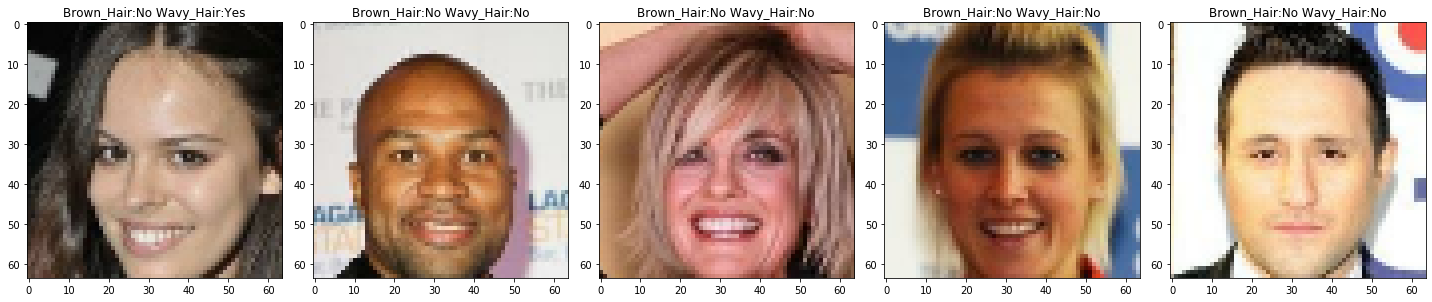

In [9]:
# 1.3
# your code here
def change_boolean(x):
    if x== True:
         return 'Yes'
    else:
        return 'No'

train_set = train_celeb.map(tf_image_attr_tuple).take(5)

fig, axes = plt.subplots(1,5, figsize=(20, 4))
for i, ((image, labels), image2) in enumerate(train_set):
    axes[i].imshow(image)
    title = 'Brown_Hair:' + str(change_boolean(labels[0])) + ' Wavy_Hair:' + str(change_boolean(labels[1]))
    axes[i].set_title(title)
plt.tight_layout()
plt.show();

---

<div class='exercise'> <b> Question 2: Set-up an AutoEncoder [20 points] </b> </div>

**Define custom convolutional layers**

We provide below the skeleton of a custom keras layer that you need to complete to build the following models. You should read the Keras [guidelines](https://www.tensorflow.org/guide/keras/custom_layers_and_models) on how to build custom layers. You are required to fill the specific methods indicated below on each part.

You will then construct an autoencoder using both custom layers, and visualize the AE image reconstruction and latent spaces.

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

**We recommend [saving](https://www.tensorflow.org/tutorials/keras/save_and_load) the trained model**.

**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

## Answers

**2.1** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvEncoder` class. We recommend to use 4 convolutional layers and dropout layers alternatively, filters of size 5x5, 'relu' activations, 'same' padding, `[9, 18, 32, 64]` channels respectively on each layer, and strides of 2x2. The intention is to halve the spatial dimensions on each convolutional layer while augmenting the number of channels on deeper layers.

You will use this layer repeatedly when building your subsequent models.

In [10]:
# 2.1

class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        ## your code here
        
        self.Conv2D_1 = layers.Conv2D(9, (5, 5), padding='same', strides=(2, 2), activation='relu',
                                      input_shape=input_shape)
        self.Dropout_1_1 = layers.Dropout(rate=dropout_rate)
        self.Conv2D_2 = layers.Conv2D(18, (5, 5), padding='same', strides=(2, 2), activation='relu')
        self.Dropout_1_2 = layers.Dropout(rate=dropout_rate)
        self.Conv2D_3 = layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu')
        self.Dropout_1_3 = layers.Dropout(rate=dropout_rate)
        self.Conv2D_4 = layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2), activation='relu')
        self.Dropout_1_4 = layers.Dropout(rate=dropout_rate)
        
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        z = self.Conv2D_1(inputs)
        z = self.Dropout_1_1(z)
        z = self.Conv2D_2(z)
        z = self.Dropout_1_2(z)
        z = self.Conv2D_3(z)
        z = self.Dropout_1_3(z)
        z = self.Conv2D_4(z)
        z = self.Dropout_1_4(z)
        
        # end of your code here
        return z

**2.2** Setup a custom layer consisting of convolutional layers and complete the `__init__` and `call` methods of the `ConvDecoder` class. We will refer to the input dimension of this layer as `latent_dim`. Make sure the output dimension of this layer is equal to the input dimension of your images, i.e., (64,64,3) if you followed our recommendation.

We recommend using `Conv2DTranspose` layers instead of `Conv2D` similar to `ConvEncoder`. Using `Conv2DTranspose` will have the desired effect in terms of inverting previous operations; for example, setting a stride of 2x2 will double the output size of the input.

In [11]:
# 2.2

class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.5, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        self.dropout_rate = dropout_rate
        
        # your code here
        
        self.Conv2DT_1 = layers.Conv2DTranspose(64, (5, 5), padding='same', strides=(2, 2), activation='relu',
                                                input_shape=input_shape)
        self.Dropout_2_1 = layers.Dropout(rate=dropout_rate)
        self.Conv2DT_2 = layers.Conv2DTranspose(32, (5, 5), padding='same', strides=(2, 2), activation='relu')
        self.Dropout_2_2 = layers.Dropout(rate=dropout_rate)
        self.Conv2DT_3 = layers.Conv2DTranspose(18, (5, 5), padding='same', strides=(2, 2), activation='relu')
        self.Dropout_2_3 = layers.Dropout(rate=dropout_rate)
        self.Conv2DT_4 = layers.Conv2DTranspose(3, (5, 5), padding='same', strides=(2, 2), activation='relu')
        self.Dropout_2_4 = layers.Dropout(rate=dropout_rate)

        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        x = self.Conv2DT_1(inputs)
        x = self.Dropout_2_1(x)
        x = self.Conv2DT_2(x)
        x = self.Dropout_2_2(x)
        x = self.Conv2DT_3(x)
        x = self.Dropout_2_3(x)
        x = self.Conv2DT_4(x)
        x = self.Dropout_2_4(x)
        
        # end your code here
        return x

**2.3** Create a Keras model `AE`. Use the previously defined `ConvEncoder` and `ConvDecoder` layer classes you just completed to build your autoencoder. Between these layers, [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the input and incorporate two intermediate [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) layers. More precisely, use the following architecture:
- Input image.
- ConvEncoder layer.
- Flatten layer.
- **Dense layer with linear activation** and `bottleneck_dim=128` units (recommended dimension).
- **Dense layer with ReLu activation**.
- Reshape layer to `latent_dim`.
- ConvDecoder layer.

In [12]:
# 2.3
# your code here
drop_rate = .1
bottleneck_dim = 128

ae_input  = layers.Input(shape=(64, 64, 3), name='AE_Input')
ae_layer  = ConvEncoder(input_shape=(64, 64, 3), dropout_rate=drop_rate, name='AE_ConvEncoder')(ae_input)
ae_layer  = layers.Flatten(name='AE_Flatten')(ae_layer)
ae_layer  = layers.Dense(bottleneck_dim, activation="linear", name='AE_Dense_Linear')(ae_layer)
ae_layer  = layers.Dense(bottleneck_dim, activation="relu", name='AE_Dense_ReLu')(ae_layer)
ae_layer  = layers.Reshape(target_shape=(4, 4, 8), name='AE_Reshape')(ae_layer)
ae_output = ConvDecoder(input_shape=(4, 4, 8), dropout_rate=drop_rate, name='AE_ConvDecoder')(ae_layer)

ae = tf.keras.Model(ae_input, ae_output, name='AE_Model')
ae.summary()

Model: "AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AE_Input (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
AE_ConvEncoder (ConvEncoder) (None, 4, 4, 64)          70448     
_________________________________________________________________
AE_Flatten (Flatten)         (None, 1024)              0         
_________________________________________________________________
AE_Dense_Linear (Dense)      (None, 128)               131200    
_________________________________________________________________
AE_Dense_ReLu (Dense)        (None, 128)               16512     
_________________________________________________________________
AE_Reshape (Reshape)         (None, 4, 4, 8)           0         
_________________________________________________________________
AE_ConvDecoder (ConvDecoder) (None, 64, 64, 3)         798

**2.4** Why do we suggest the first dense layer after the `ConvEncoder` layer use `linear` activation in the `AE` model? Is it necessary requirement or not? Explain your answer.

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**2.5** Train the `AE` model (use MSE loss criterion and an optimizer of your choice). We found 5 epochs sufficed to train our model (feel free to adjust this value). Print a summary of the model. 

In [13]:
# 2.5
# your code here
epochs = 5
verbose = 1

optimizer = optimizers.Adam(lr=0.001)
loss = "mse"

ae.compile(optimizer=optimizer, loss=loss)

ae_history = ae.fit(train_ds, epochs=epochs, verbose=verbose, validation_data=(val_ds))

ae.save_weights("../model/ae_weights.h5")

Epoch 1/5
5087/5087 [==============================] - 199s 39ms/step - loss: 0.0434 - val_loss: 0.0000e+00
Epoch 2/5
5087/5087 [==============================] - 188s 37ms/step - loss: 0.0378 - val_loss: 0.0163
Epoch 3/5
5087/5087 [==============================] - 188s 37ms/step - loss: 0.0369 - val_loss: 0.0118
Epoch 4/5
5087/5087 [==============================] - 189s 37ms/step - loss: 0.0366 - val_loss: 0.0122
Epoch 5/5
5087/5087 [==============================] - 188s 37ms/step - loss: 0.0364 - val_loss: 0.0139


**2.6** Visualize 5 random original and reconstructed images fed to the autoencoder from the validation data.

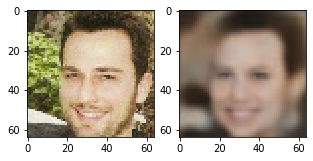

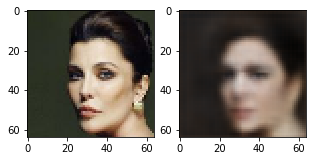

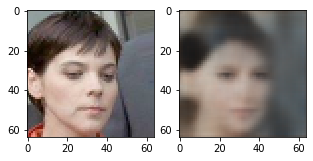

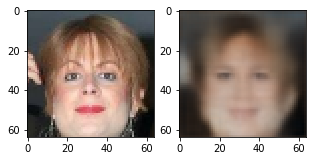

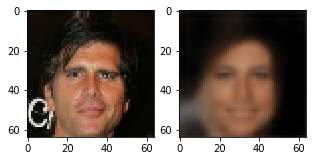

In [14]:
# 2.6
# your code here
ae.load_weights("../model/ae_weights.h5")

val_set = val_celeb.map(tf_image_tuple).take(5)
val_pred = ae.predict(val_set.batch(32).prefetch(2))

for i, (image, image2) in enumerate(val_set):
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(image)
    axes[1].imshow(val_pred[i])
plt.show();

**2.7** Visualize the first 2 [principal components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection onto the plane of the latent representation of the validation images. Use the representation after the first dense layer where `bottleneck_dim=128` to compute the PCs and t-SNE projections. Retrieve at least `1024` images and color each input by class type, for example, `Male` and `Smiling` (if these where your chosen attributes), for **each scatter plot visualization** and attributes. You need to present 4 scatter plots in total. Explain your results.

In [15]:
# 2.7 (PCA visualization)
# your code here
drop_rate = .1
optimizer = optimizers.Adam(lr=0.001)
loss = "mse"

# from HW6
def create_truncated_model(trained_model):
    i_put = layers.Input(shape=(64, 64, 3))
    layer = ConvEncoder(input_shape=(64, 64, 3), dropout_rate=drop_rate)(i_put)
    layer = layers.Flatten()(layer)
    o_put = layers.Dense(bottleneck_dim, activation="linear")(layer)
    model = tf.keras.Model(i_put, o_put)
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss)
    return model

val_set = val_celeb.map(tf_image_attr_tuple).take(5)
val_pred = ae.predict(val_set.batch(32).prefetch(2))

truncated_model = create_truncated_model(ae)
hidden_features = truncated_model.predict(val_pred)

Text(0.5, 1.0, 'First 2 Principal Components for AE Model')

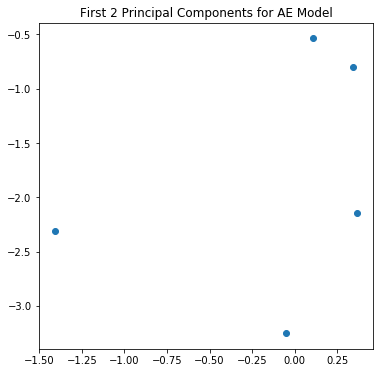

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.scatter(hidden_features[:, 0], hidden_features[:, 1])
ax.set_title("First 2 Principal Components for AE Model")

0
0
1
1
0


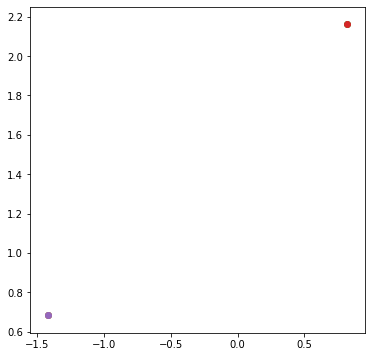

In [16]:
lbl = ['Yes','No']

fig, ax = plt.subplots()
fig.set_size_inches(6,6)
for i, ((image, labels), image2) in enumerate(val_set):
    title = 'Brown_Hair:' + str(change_boolean(labels[0])) + ' Wavy_Hair:' + str(change_boolean(labels[1]))
    print(np.array(int(labels[0])))
    ax.scatter(pca_result[np.array(int(labels[0])), 0], pca_result[np.array(int(labels[0])), 1], label=lbl)

#ax.set_title("First 2 PCA Components for AE Model")

*Your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

Compute also the t-SNE decomposition of the latent images. Does it uncover any characteristic structure? Please, explain your answer

Text(0.5, 1.0, 'First 2 t-SNE Components for AE Model')

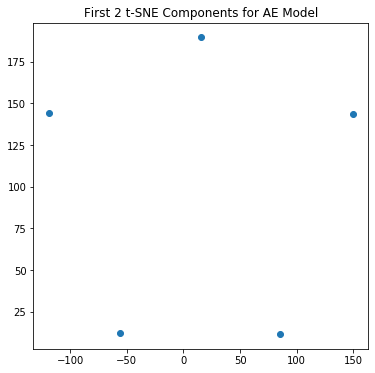

In [17]:
# 2.7 (t-SNE visualization)
# your code here
tsne_result = TSNE(n_components=2).fit_transform(hidden_features)

fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax.scatter(tsne_result[:, 0], tsne_result[:, 1])
ax.set_title("First 2 t-SNE Components for AE Model")

*Your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

---

In [ ]:
"""
dropout_rate=0.1
test = tf.keras.Sequential()
test.add(layers.Input(shape=(32,32,3)))
test.add(layers.Conv2D(9, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.add(layers.Conv2D(18, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.add(layers.Conv2D(32, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.add(layers.Conv2D(64, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.add(layers.Flatten())
test.add(layers.Dense(128, activation="linear"))
test.add(layers.Dense(128, activation="relu"))
test.add(layers.Reshape(target_shape=(2,2,32)))
test.add(layers.Conv2DTranspose(64, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.add(layers.Conv2DTranspose(32, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.add(layers.Conv2DTranspose(18, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.add(layers.Conv2DTranspose(3, (5, 5), padding ='same', strides=(2, 2), activation='relu'))
test.add(layers.Dropout(rate=dropout_rate))
test.summary()

In [ ]:
"""
epochs = 5
verbose = 1

optimizer = optimizers.Adam(lr=0.001)
loss = "mse"

test.compile(optimizer=optimizer, loss=loss)

test_history = test.fit(train_ds, epochs=epochs, verbose=verbose, validation_data=(val_ds))

<div class='exercise'> <b> Question 3: Set-up a Convolutional Variational Autoencoder [20 points].</b> </div>

In this exercise you will code a standard Variational Autoencoder. You will first create a custom layer `Sampling` that takes the mean and log-variance of a Gaussian distribution as inputs, and returns a sample from that distribution. You will use this sample as a latent representation of your probabilistic encoder conditioned on the input image, and use it to reconstruct an image. You will build the complete VAE architecture and study its properties.

You will need to minimize the negative ELBO function formed by a reconstruction loss and a regularization term over the mean and variance of the probabilistic encoder. You will train two VAE models, one with no regularization, and a second with regularization.

Follow these instructions:

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

**3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

## Answers

**3.1** Complete the `call` function of Sampling keras layer. This function takes as input the mean and log-variance vectors of a multivariate Gaussian distribution and returns a sampled tensor from this distribution.

In [18]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        # your code here
        
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


**3.2** Create two  Variational AutoEncoder models named `VAE1` and `VAE2`. Use the `ConvEncoder` and `ConvDecoder` layer classes you completed in Question 2 and the `Sampling` layer from 3.1. Both VAEs should have the following architecture:
- Input image.
- ConvEncoder.
- Flatten layer.
- Dense layer with linear activation and 128 units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and 128 units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- Dense layer with ReLu activation.
- Reshape layer: reshapes the output of dense into `latent_dim`.
- ConvDecoder.

Finally, `VAE1` should not use any regularization of the probabilistic encoder (from the prior). 

Instead, `VAE2` should incorporate a KL loss to regularize the probabilistic encoder to normal Gaussian of zero mean and unit variance acting as prior, as explained in class. 
You may use the following expression: `kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)`, where a reasonable value for `reg = 0.1` (feel free to adjust).
To include the intermediate loss in `VAE2`, you may use the function `add_loss` from keras models/layers as explained in the [documentation](https://www.tensorflow.org/guide/keras/train_and_evaluate). 

**We recommend saving your trained models.**

In [26]:
# 3.2 
# your code here
vae1_input  = layers.Input(shape=(64, 64, 3), name='VAE1_Input')
vae1_layer  = ConvEncoder(input_shape=(64, 64, 3), dropout_rate=drop_rate, name='VAE1_ConvEncoder')(vae1_input)
vae1_layer  = layers.Flatten(name='VAE1_Flatten')(vae1_layer)
vae1_z_mean = layers.Dense(bottleneck_dim, activation="linear", name='VAE1_z_mean')(vae1_layer)
vae1_z_log_var = layers.Dense(bottleneck_dim, activation="linear", name='VAE1_z_log_var')(vae1_layer)
vae1_layer  = Sampling(name='VAE1_Sampling')((vae1_z_mean, vae1_z_log_var))
vae1_layer  = layers.Dense(128, activation="relu", name='VAE1_Dense_ReLu')(vae1_layer)
vae1_layer  = layers.Reshape(target_shape=(4, 4, 8), name='VAE1_Reshape')(vae1_layer)
vae1_output = ConvDecoder(input_shape=(4, 4, 8), dropout_rate=drop_rate, name='VAE_ConvDecoder')(vae1_layer)

vae1 = tf.keras.Model(vae1_input, vae1_output, name='VAE1_Model')
vae1.summary()

Model: "VAE1_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE1_Input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
VAE1_ConvEncoder (ConvEncoder)  (None, 4, 4, 64)     70448       VAE1_Input[0][0]                 
__________________________________________________________________________________________________
VAE1_Flatten (Flatten)          (None, 1024)         0           VAE1_ConvEncoder[0][0]           
__________________________________________________________________________________________________
VAE1_z_mean (Dense)             (None, 128)          131200      VAE1_Flatten[0][0]               
_________________________________________________________________________________________

In [27]:
vae2_input  = layers.Input(shape=(64, 64, 3), name='VAE2_Input')
vae2_layer  = ConvEncoder(input_shape=(64, 64, 3), dropout_rate=drop_rate, name='VAE2_ConvEncoder')(vae2_input)
vae2_layer  = layers.Flatten(name='VAE2_Flatten')(vae2_layer)
vae2_z_mean = layers.Dense(bottleneck_dim, activation="linear", name='VAE2_z_mean')(vae2_layer)
vae2_z_log_var = layers.Dense(bottleneck_dim, activation="linear", name='VAE2_z_log_var')(vae2_layer)
vae2_layer  = Sampling(name='VAE2_Sampling')((vae2_z_mean, vae2_z_log_var))
vae2_layer  = layers.Dense(128, activation="relu", name='VAE2_Dense_ReLu')(vae2_layer)
vae2_layer  = layers.Reshape(target_shape=(4, 4, 8), name='VAE2_Reshape')(vae2_layer)
vae2_output = ConvDecoder(input_shape=(4, 4, 8), dropout_rate=drop_rate, name='VAE2_ConvDecoder')(vae2_layer)

vae2 = tf.keras.Model(vae2_input, vae2_output, name='VAE2_Model')

reg = 0.1
kl_loss = - reg * 0.5 * tf.reduce_mean(vae2_z_log_var - tf.square(vae2_z_mean) - tf.exp(vae2_z_log_var) + 1)
vae2.add_loss(kl_loss)

vae2.summary()

Model: "VAE2_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE2_Input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
VAE2_ConvEncoder (ConvEncoder)  (None, 4, 4, 64)     70448       VAE2_Input[0][0]                 
__________________________________________________________________________________________________
VAE2_Flatten (Flatten)          (None, 1024)         0           VAE2_ConvEncoder[0][0]           
__________________________________________________________________________________________________
VAE2_z_mean (Dense)             (None, 128)          131200      VAE2_Flatten[0][0]               
_________________________________________________________________________________________

**3.3** Why do we use linear activation values to encode the mean and log-variance of the probabilistic encoder? Explain your answer.

*Your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**3.4** Visualize 1 original image and 5 reconstructed images from the validation data fed to `VAE1` and `VAE2`. Comment on the reconstructed images. Notice that you may need to tune penalty regularization term to observe differences between `VAE1` and `VAE2` (there should be differences!).

In [28]:
# 3.4
# your code here
epochs = 5
verbose = 1

optimizer = optimizers.Adam(lr=0.001)
loss = "mse"

vae1.compile(optimizer=optimizer, loss=loss)

vae1_history = vae1.fit(train_ds, epochs=epochs, verbose=verbose, validation_data=(val_ds))

vae1.save_weights("../model/vae1_weights.h5")

Epoch 1/5
5087/5087 [==============================] - 199s 39ms/step - loss: 0.0426 - val_loss: 0.0000e+00
Epoch 2/5
5087/5087 [==============================] - 190s 37ms/step - loss: 0.0377 - val_loss: 0.0134
Epoch 3/5
5087/5087 [==============================] - 191s 37ms/step - loss: 0.0371 - val_loss: 0.0132
Epoch 4/5
5087/5087 [==============================] - 190s 37ms/step - loss: 0.0368 - val_loss: 0.0136
Epoch 5/5
5087/5087 [==============================] - 191s 38ms/step - loss: 0.0366 - val_loss: 0.0124


In [29]:
epochs = 5
verbose = 1

optimizer = optimizers.Adam(lr=0.001)
loss = "mse"

vae2.compile(optimizer=optimizer, loss=loss)

vae2_history = vae2.fit(train_ds, epochs=epochs, verbose=verbose, validation_data=(val_ds))

vae2.save_weights("../model/vae2_weights.h5")

Epoch 1/5
5087/5087 [==============================] - 202s 40ms/step - loss: 0.0648 - val_loss: 0.0000e+00
Epoch 2/5
5087/5087 [==============================] - 193s 38ms/step - loss: 0.0585 - val_loss: 0.0380
Epoch 3/5
  1/621 [..............................] - ETA: 18:22:40

KeyboardInterrupt: 

In [ ]:
vae1.load_weights("../model/vae1_weights.h5")
vae2.load_weights("../model/vae2_weights.h5")

val_set = val_celeb.map(tf_image_tuple).take(5)

val_pred1 = vae1.predict(val_set.batch(32).prefetch(2))
val_pred2 = vae2.predict(val_set.batch(32).prefetch(2))

for i, (image, image2) in enumerate(val_set):
    fig, axes = plt.subplots(1, 3, figsize=(5, 5))
    axes[0].imshow(image)
    axes[1].imshow(val_pred1[i])
    axes[2].imshow(val_pred2[i])
plt.show();

*your explanation here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**3.5** Visualize the first 2 principal components (PCs) and the t-SNE decomposition of the validation data on both `VAE1` and `VAE2` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for a given input. Color the datapoints depending on the input's attributes of your choice (`Male` and `Smiling` if these were your choice). Draw four separate scatterplots in total. Explain what you observe.

In [ ]:
# 3.5
# your code here


**Explanation of PCA visualization:** 

*your explanation here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

In [ ]:
# 3.5
# your code here


**Explanation of t-SNE decomposition:** 

*your explanation here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

<div class='exercise'> <b> Question 4: Set-up a Conditional VAE. [20 points] </b> </div>

Conditional VAEs are similar to standard VAEs were you incorporate an input's label/information into the latent space. When the model is trained in this form, the model learns to distinguish between these features. For example, you can select features on latent space manually, and explore the space of representations in an explicit manner. We point you to [one](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/) and [two](https://ijdykeman.github.io/ml/2016/12/21/cvae.html) short tutorials on conditional VAEs. Additionally, you may be interested in reading the [original paper](http://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf), or a [continuation paper](https://papers.nips.cc/paper/7880-learning-latent-subspaces-in-variational-autoencoders.pdf). 

In this exercise you are going to build a conditional VAE, and reconstruct images by altering their attributes. For example, pick a set of 'not smiling men' and transform them by changing the label conditions such as 'smile' or 'gender' in latent space. You can choose whatever attributes you want, as long as the reconstructed latent space shows reasonable success when changing the attribute labels.

Follow this set of instructions:

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

**4.2** Train the model using the data generator you completed in Question 1.2 (use mean squared error loss and an optimizer of your choice). Print a summary of your model.

**We recommend saving your trained models**.

**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

For example, if your choice of attributes where 'Male' and 'Smiling', you should reconstruct these images with all possible attribute combinations.

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

## Answers

**4.1** Create a conditional VAE keras model named `CVAE`. The conditional VAE should have the following architecture:
- Input for image.
- Input for attributes.
- ConvEncoder layer.
- Flatten layer: flattens the output of the ConvEncoder.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate): concatenates the latent representation of dimension `latent_dim[0]*latent_dim[1]*latent_dim[2]` with two attribute codes of your choice (tf.float32 representations).
- Dense layer with linear activation and `bottleneck_dim` units to predict the mean of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Dense layer with linear activation and `bottleneck_dim` units to predict the log-variance of the encoder conditional distribution $q_x(z)=N(\mu,\sigma)$.
- Sampling layer you completed in Question 3.1.
- [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) that combines your sample with the two attribute codes of your choice (tf.float32 representations).
- Dense layer with ReLu activation.
- Reshape layer.
- ConvDecoder.
- Output image of same size as input image.

In [ ]:
# 4.1
# your code here
tf.keras.backend.clear_session()

cae_in_img = layers.Input(shape=(32,32,3), name='CAE_Input_img')
cae_in_att = layers.Input(shape=(2,), name='CAE_Input_att')
cae_layer  = ConvEncoder(input_shape=(32,32,3), dropout_rate=drop_rate, name='CAE_ConvEncoder')(cae_in_img)
cae_layer  = layers.Flatten(name='CAE_Flatten')(cae_layer)
cae_layer  = layers.concatenate([cae_layer, cae_in_att], axis=1, name='CAE_Concatenate_1')
#cae_layer  = tf.keras.layers.Concatenate(name='CAE_Concatenate_1')([cae_layer], cae_in_att)
cae_z_mean = layers.Dense(bottleneck_dim, name='CAE_z_mean')(cae_layer)
cae_layer  = layers.Dense(bottleneck_dim, activation='linear', name='CAE_Dense_Linear_1')(cae_z_mean)
cae_z_log_var = layers.Dense(bottleneck_dim, name='CAE_z_log_var')(cae_layer)
cae_layer  = layers.Dense(bottleneck_dim, activation='linear', name='CAE_Dense_Linear_2')(cae_z_log_var)
cae_layer  = Sampling(name='CAE_Sampling')((cae_z_mean, cae_z_log_var))
cae_layer  = layers.concatenate([cae_layer, cae_in_att], axis=1, name='CAE_Concatenate_2')
#cae_layer  = tf.keras.layers.Concatenate(name='CAE_Concatenate_2')([cae_layer, cae_in_att])
cae_layer  = layers.Reshape(target_shape=(2,2,32), name='CAE_Reshape')(cae_layer)
cae_output = ConvDecoder(input_shape=(2,2,32), dropout_rate=drop_rate, name='CAE_ConvDecoder')(cae_layer)

cae = tf.keras.Model(cae_in_img, cae_output, name='CAE_Model')
cae.summary()

**4.2** Train the model using the generator you completed in Q1.3. Print a summary of your model.
**We recommend saving your trained models**.

In [77]:
# 4.2
# your code here
epochs = 5
verbose = 1

optimizer = optimizers.Adam(lr=0.001)
loss = "mse"

cae.compile(optimizer=optimizer, loss=loss)

cae_history = cae.fit(train_cond_ds, epochs=epochs, verbose=verbose, validation_data=(val_cond_ds))

cae.save_weights("../model/cae_weights.h5")

Epoch 1/5
5087/5087 [==============================] - 184s 36ms/step - loss: 0.0394 - val_loss: 0.0000e+00- 163s 35ms/step - loss: 0.03 - 163s 35ms/step - loss: 0. - 163 - 164s 34ms/st - 164s 34ms/step - loss: 0.03 - 164s 34ms/st - 164s 34ms/step - 165s 34ms - 165s 34ms/step - - 165s 34ms/step - loss: 0.0 - 165s 34ms/step - 165s
Epoch 2/5
5087/5087 [==============================] - 169s 33ms/step - loss: 0.0392 - val_loss: 0.0141
Epoch 3/5
5087/5087 [==============================] - 173s 34ms/step - loss: 0.0391 - val_loss: 0.0127
Epoch 4/5
5087/5087 [==============================] - 170s 33ms/step - loss: 0.0390 - val_loss: 0.0136
Epoch 5/5
5087/5087 [==============================] - 169s 33ms/step - loss: 0.0389 - val_loss: 0.0126


**4.3** Select 5 photos with common attributes and reconstruct these images after feeding them to the conditional variational autoencoder `CVAE` from the validation data. Change attributes in the other three possible combinations and visualize all compositions. Comment on your compositions.

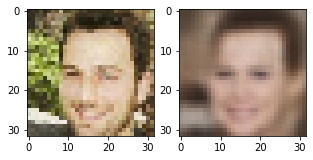

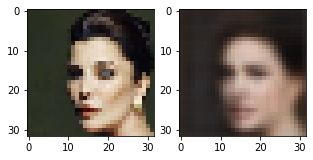

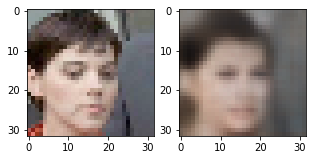

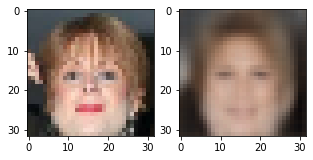

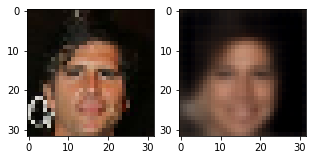

In [23]:
# 4.3
# Example case: select 5 images of men, not smiling; reconstruct with smiling and no smiling, and as smiling/no-smiling women.
# your code here
cae.load_weights("../model/cae_weights.h5")

val_set = val_celeb.map(tf_image_attr_tuple).take(5)
val_pred = cae.predict(val_set.batch(32).prefetch(2))

for i, ((image, labels), image2) in enumerate(val_set):
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(image)
    axes[1].imshow(val_pred[i])
plt.show();

*Your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**4.4** Visualize the first 2 principal components and the t-SNE decomposition of the validation data of `CVAE` obtained from the latent space, i.e., a sample drawn from the probabilistic encoder for at least 1024 input images. Color the datapoints depending on the input's attributes `male` and `smiling`: draw four separate scatterplots in total. Explain what you observe.

In [ ]:
# 4.4
# your code here


*Your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

In [ ]:
# 4.4
# your code here


*Your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

---

<div class='exercise'> <b> Question 5: Generative Adversarial Networks. [20 points] </b> </div>

For the final exercise we are going to create a standard GAN composed of a generator, and a discriminator. GANs are tricky to train, so we encourage you to follow the given instructions when training your models. However, feel completely free to explore and present other layer architectures if they present better results.

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.

**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

**5.5** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.

## Answers

**5.1** Create a convolutional keras generator model. We recommend the follow architecture.

- Input to the generator is a noise vector of dimension `bottleneck_dim`. You can rename to `noise_dim` for more corresponding terminology if you prefer.
- Dense layer with `latent_dim[0]*latent_dim[1]*latent_dim[2]` units, and LeakyRelu.
- Reshape to `latent_dim`.
- 3x Conv2DTranspose layers with 5x5 filters, LeakyRelu's, stride 2x2, 'same' padding.

For stability, consider training without bias terms on your Dense and Conv2DTranspose layers. Print a summary of your model.

In [47]:
# 5.1
# your code here
noise_dim = bottleneck_dim
tf.keras.backend.clear_session()

g_input = layers.Input(shape=(noise_dim,), name='G_Input')
g_layer = layers.Dense(32*32*3, use_bias=False, activation=layers.LeakyReLU(), name='G_Dense')(g_input)
g_layer = layers.Reshape(target_shape=(4, 4, 32), name='G_Reshape')(g_layer)
g_layer = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, name='G_Conv2DT_1')(g_layer)
g_layer = layers.LeakyReLU(name='G_LeakyReLU_2')(g_layer)
g_layer = layers.Conv2DTranspose(18, (5, 5), strides=(2, 2), padding='same', use_bias=False, name='G_Conv2DT_2')(g_layer)
g_layer = layers.LeakyReLU(name='G_LeakyReLU_3')(g_layer)
g_layer = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, name='G_Conv2DT_3')(g_layer)
g_output = layers.LeakyReLU(name='G_LeakyReLU_4')(g_layer)

generator = tf.keras.Model(g_input, g_output, name='Generator_Model')
generator.summary()

optimizer = optimizers.Adam(lr=0.001)
loss = "binary_crossentropy"

generator.compile(optimizer=optimizer, loss=loss)

Model: "Generator_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_Input (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
G_Dense (Dense)              (None, 3072)              393216    
_________________________________________________________________
G_Reshape (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
G_Conv2DT_1 (Conv2DTranspose (None, 8, 8, 64)          51200     
_________________________________________________________________
G_LeakyReLU_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
G_Conv2DT_2 (Conv2DTranspose (None, 16, 16, 18)        28800     
_________________________________________________________________
G_LeakyReLU_3 (LeakyReLU)    (None, 16, 16, 18)    

**5.2** Create a convolutional discriminator model. Our recommended setup is to use 3x Conv2D layers with filters of size (4,4), 'same' padding, strides 2x2, and LeakyRelu activations. Compile the model with binary cross entropy loss and an optimizer of your choice. Print a summary of the model.

In [48]:
# 5.2
# your code here
d_input = layers.Input(shape=(32, 32, 3), name='D_Input')
d_layer = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3), name='D_Conv2D_1')(d_input)
d_layer = layers.LeakyReLU(name='D_LeakyReLU_1')(d_layer)
d_layer = layers.Conv2D(18, (4, 4), strides=(2, 2), padding='same', name='D_Conv2D_2')(d_layer)
d_layer = layers.LeakyReLU(name='D_LeakyReLU_2')(d_layer)
d_layer = layers.Conv2D(3, (4, 4), strides=(2, 2), padding='same', name='D_Conv2D_3')(d_layer)
d_output = layers.LeakyReLU(name='D_LeakyReLU_3')(d_layer)

discriminator = tf.keras.Model(d_input, d_output, name='Discriminator_Model')
discriminator.summary()

optimizer = optimizers.Adam(lr=0.001)
loss = "binary_crossentropy"

discriminator.compile(optimizer=optimizer, loss=loss)

Model: "Discriminator_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D_Input (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
D_Conv2D_1 (Conv2D)          (None, 16, 16, 64)        3136      
_________________________________________________________________
D_LeakyReLU_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
D_Conv2D_2 (Conv2D)          (None, 8, 8, 18)          18450     
_________________________________________________________________
D_LeakyReLU_2 (LeakyReLU)    (None, 8, 8, 18)          0         
_________________________________________________________________
D_Conv2D_3 (Conv2D)          (None, 4, 4, 3)           867       
_________________________________________________________________
D_LeakyReLU_3 (LeakyReLU)    (None, 4, 4, 3)   

**5.3** Create a DCGAN model that is a composition of the generator and the discriminator. The DCGAN model takes a Gaussian vector as input into the generator, and then the discriminator decides whether the output comes from the generator or from the true distristribution. The DCGAN is composed of the trainable weights of the generator, and fixed discriminator weights. You can accompolish this behavior by fixing the discriminator training weights using `discriminator.trainable = False` before constructing the model. Once you have instantiated the DCGAN model, compile it with a binary cross entropy loss and optimizer of your choice.


In [50]:
# 5.3
# your code here
noise = np.random.randn(12800, 1)

discriminator.trainable = False

dcgan_input  = layers.Input(shape=(noise_dim,))
dcgan_layer  = generator(dcgan_input)
dcgan_output = discriminator(dcgan_layer)

dcgan = tf.keras.Model(dcgan_input, dcgan_output, name='DCGAN_Model')

optimizer = optimizers.Adam(lr=0.001)
loss = "binary_crossentropy"
metrics=['accuracy']

dcgan.compile(optimizer=optimizer, loss=loss, metrics=metrics)

**5.4** Train your model (both DCGAN and discriminator) on the train images of the celeba dataset. We recommend you display images after every train epoch to visualize performance. You should observe 'sensible' images after around 5 epochs or less, specially if you train on the full dataset. Consider training on a reduced set of the dataset if it takes too long. 

To train your DCGAN model, you will not be able to use the model's [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function. Instead, you should consider using [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) method, where you can manually feed an input and training labels, and alternate between the DCGAN and the discriminator. Datasets are `iterable`, so you can use them directly in a for loop to obtain mini-batches. You need to run these three steps inside the for loop: 
1) Train on batch the discriminator on real images with labels equal to 1 (optionally, minus a small smoother). The smoother may help the generator train faster than the discriminator.
2) Train on batch the discriminator on generated images obtained from random Gaussian input and labels equal to 0.
3) Train on batch the DCGAN by feeding noise inputs and labels of 1's.

**Show at least 8 generated images from your final trained DCGAN model for submission**. How do these images compare in quality to the faces generated via VAE? Explain.

In [56]:
# 5.4
# your code here
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, noise_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

losses = {"D":[], "G":[]}

def train(DATA=None, epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(DATA.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
            
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = DATA[np.random.randint(0, DATA.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

In [58]:
train(DATA=train_cond_ds, epochs=1, plt_frq=10, BATCH_SIZE=batch_size)

AttributeError: 'DatasetV1Adapter' object has no attribute 'shape'

In [57]:
tf.keras.backend.int_shape(train_cond_ds)

AttributeError: 'DatasetV1Adapter' object has no attribute 'shape'

*your explanation here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**5.5** Standard GANs are composed as a generator and discriminator, as you just coded them. Could we substitute the discriminator with something else, like a KL loss with the empirical distribution? Why or why not? Explain your answer.



*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

---